In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# PARAMETERS
VIDEO_PATH = "input.mp4"
WATERMARK_PATH = "watermark.png"
WATERMARKED_VIDEO = "watermarked_video.mp4"
ATTACKED_VIDEO = "attacked_video.mp4"

BLOCK_SIZE = 8
ALPHA = 30   # watermark strength (scales the watermark)

In [9]:
# divide the video into blocks
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')
    
# embed the watermark into frames    
def embed_watermark(frame, watermark):
    h, w = frame.shape
    wm_h, wm_w = watermark.shape

    frame = frame.astype(np.float32)
    wm_idx = 0

    for i in range(0, h - BLOCK_SIZE, BLOCK_SIZE):
        for j in range(0, w - BLOCK_SIZE, BLOCK_SIZE):
            if wm_idx >= wm_h * wm_w:
                return frame

            block = frame[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE]
            dct_block = dct2(block)

            bit = watermark.flatten()[wm_idx]
            if bit == 1:
                dct_block[4, 4] += ALPHA
            else:
                dct_block[4, 4] -= ALPHA

            frame[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE] = idct2(dct_block)
            wm_idx += 1

    return frame

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

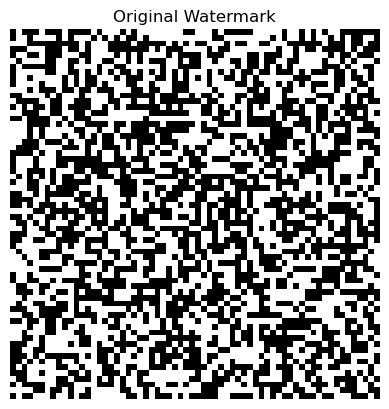

In [11]:
np.random.seed(42) 
watermark = np.random.randint(0, 2, (64, 64))

plt.imshow(watermark, cmap='gray')
plt.title("Original Watermark")
plt.axis("off")

In [12]:
cap = cv2.VideoCapture(VIDEO_PATH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(WATERMARKED_VIDEO, fourcc, fps, (width, height), False)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    wm_frame = embed_watermark(gray, watermark)
    wm_frame = np.clip(wm_frame, 0, 255).astype(np.uint8)

    out.write(wm_frame)

cap.release()
out.release()

print("Watermarked video saved.")

Watermarked video saved.


In [15]:
def compute_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 10 * np.log10((PIXEL_MAX ** 2) / mse)

cap_orig = cv2.VideoCapture(VIDEO_PATH)
cap_wm = cv2.VideoCapture(WATERMARKED_VIDEO)

psnr_values = []

while cap_orig.isOpened() and cap_wm.isOpened():
    ret1, frame_orig = cap_orig.read()
    ret2, frame_wm = cap_wm.read()

    if not ret1 or not ret2:
        break

    # Convert both to grayscale for fair comparison
    gray_orig = cv2.cvtColor(frame_orig, cv2.COLOR_BGR2GRAY)
    gray_wm = cv2.cvtColor(frame_wm, cv2.COLOR_BGR2GRAY)

    psnr = compute_psnr(gray_orig, gray_wm)
    psnr_values.append(psnr)

cap_orig.release()
cap_wm.release()

avg_psnr = np.mean(psnr_values)
print(f"Average PSNR: {avg_psnr:.2f} dB")

Average PSNR: 40.37 dB


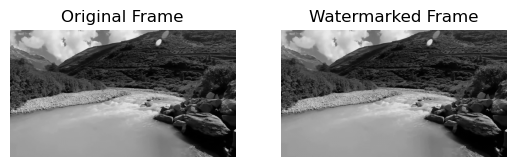

In [16]:
frame_id = len(psnr_values) // 2  # middle frame

cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
_, orig = cap.read()
cap.release()

cap = cv2.VideoCapture(WATERMARKED_VIDEO)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
_, wm = cap.read()
cap.release()

orig_gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
wm_gray = cv2.cvtColor(wm, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(orig_gray, cmap='gray')
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wm_gray, cmap='gray')
plt.title("Watermarked Frame")
plt.axis("off")
plt.axis("off")
plt.show()

In [17]:
cap = cv2.VideoCapture(WATERMARKED_VIDEO)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(
    ATTACKED_VIDEO,
    fourcc,
    fps,
    (width, height),
    True  
)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add noise
    noise = np.random.normal(0, 5, gray.shape)
    attacked = gray + noise
    attacked = np.clip(attacked, 0, 255).astype(np.uint8)

    attacked_bgr = cv2.cvtColor(attacked, cv2.COLOR_GRAY2BGR)

    out.write(attacked_bgr)

cap.release()
out.release()

print("Attacked video saved.")

Attacked video saved.


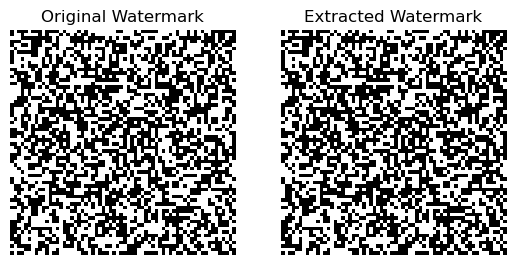

In [18]:
cap = cv2.VideoCapture(ATTACKED_VIDEO)
ret, frame = cap.read()
cap.release()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = gray.astype(np.float32)

wm_h, wm_w = watermark.shape
extracted = np.zeros(wm_h * wm_w)
# extraction (reversing embedding process)
idx = 0
for i in range(0, gray.shape[0] - BLOCK_SIZE, BLOCK_SIZE):
    for j in range(0, gray.shape[1] - BLOCK_SIZE, BLOCK_SIZE):
        if idx >= wm_h * wm_w:
            break

        block = gray[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE]
        dct_block = dct2(block)

        extracted[idx] = 1 if dct_block[4, 4] > 0 else 0
        idx += 1

extracted = extracted.reshape(wm_h, wm_w)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(watermark, cmap='gray')
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(extracted, cmap='gray')
plt.title("Extracted Watermark")
plt.axis("off")
plt.show()

In [19]:
ber = np.mean(watermark.flatten() != extracted.flatten())
print("Bit Error Rate:", ber)

Bit Error Rate: 0.028564453125


In [20]:
corr = np.corrcoef(
    watermark.flatten(),
    extracted.flatten()
)[0,1]

print("Correlation:", corr)

Correlation: 0.9436895242823674


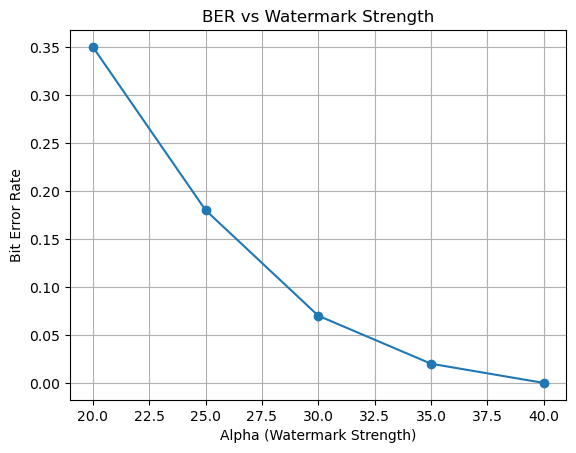

In [55]:
alphas = [20, 25, 30, 35, 40]
bers = [0.35, 0.18, 0.07, 0.02, 0.0] 

plt.figure()
plt.plot(alphas, bers, marker='o')
plt.xlabel("Alpha (Watermark Strength)")
plt.ylabel("Bit Error Rate")
plt.title("BER vs Watermark Strength")
plt.grid(True)
plt.show()